# t-Distributed Stochastic Neighbor Embedding (t-SNE)

In this exercise, you will implement elements of the t-SNE algorithm described in the paper by Laurens van der Maaten (available on ISIS), and analyze its behavior. As a reminder, here are the main steps of the t-SNE procedure described in the paper:

* compute pairwise affinities $p_{j|i}$ with perplexity perp using $p_{j|i} = \frac{\exp(-||x_i - x_j||^2/2\sigma^2)}{\sum_{k \neq i} \exp(-||x_i - x_k||^2/2\sigma^2)}$

* Optimize the perplexity for each element i to give the target perplexity (provided in `utils.py`)

* Symmetrize the affinity matrix using $p_{ij} = \frac{p_{j|i}+p_{i|j}}{2N}$

* Consider an initial embedding $Y^{0}$


* Repeat for multiple iterations:

   * Compute the affinities in the embedded space $q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k \neq i}(1 + ||y_i - y_k||^2)^{-1}}$
   
   * Compute the gradient $\frac{\partial C}{\partial Y}$ using $\frac{\partial C}{\partial Y_i} = 4 \sum_{j} (p_{ij}-q_{ij})(y_i-y_j)(1 + ||y_i - y_j||^2)^{-1}$
   
   * Update the embedding using the update rule $Y^{t} = Y^{t-1} + \eta \frac{\partial C}{\partial Y} + \alpha (t)( Y^{t-1}-Y^{t-2})$, where $Y^{t}$ is the value of $Y$ at time $t$, where $Y^{t}=(0,0,...,0)$ for $t < 0$ and where $\alpha (t) = 0.5$ at the beginning of the training procedure and $0.8$ towards the end.
   

* Return the final embedding $Y^{T}$ where $T$ is the number of iterations

## Implementing t-SNE (30P)

You are asked to implement several functions that are used by the t-SNE algorithm. Their specification is given below. In their current form, they simply call functions of the module `solutions`, which is not provided. Replace these calls by your own implementation of the functions. Remark that most of the time, we work with log-probabilities. It is more convenient and numerically stable when the probabilities need to be defined or normalized. (See for example the function `scipy.misc.logsumexp` for that purpose.)

In [1]:
def student(Y):
    
    d_y_ij = 1 + distance.cdist(Y, Y, 'sqeuclidean')
    logQ =  np.log(np.reciprocal(d_y_ij)) - np.log(np.sum(np.reciprocal(d_y_ij)))

    return logQ

def objective(logP,logQ):
    
    C = np.sum((np.exp(logP)*logP)-(np.exp(logP)*logQ))
    
    return C

def gradient(logP,Y):
    
    P,Q = np.exp(logP), np.exp(student(Y))
    d_y_ij = np.reciprocal(1 + distance.cdist(Y, Y, 'sqeuclidean'))
    
    gradY = np.zeros(Y.shape)
    for i in range(Y.shape[0]):
        gradY[i] = 4*np.dot((P[i]-Q[i])*d_y_ij[i], (Y[i]-Y))
    
    return gradY

The code below implements t-SNE algorithm. It takes as input some unsupervised dataset `X` (a `Nxd` array), and compute a two-dimensional embedding starting from an initial embedding `Y0` (a `Nx2` array). Various training parameters can be specified as optional parameters. The t-SNE algorithm makes use of the functions that are defined above.

In [2]:
import utils
import numpy as np
from scipy.spatial import distance

def TSNE(X,Y0,perplexity=25,learningrate=1.0,nbiterations=250, plot=False, info=True):

    N,d = X.shape
    
    if info==True: print('get affinity matrix')
    
    # get the affinity matrix in the original space
    logP = utils.getaffinity(X,perplexity,info)
    
    # create initial embedding and update direction
    Y  = Y0*1
    dY = Y*0
    
    if info==True: print('run t-SNE')
    
    for t in range(nbiterations):

        # compute the pairwise affinities in the embedding space
        logQ = student(Y)
        
        # monitor objective
        if t %50 == 0 and plot == False and info==True: print('%3d %.3f'%(t,objective(logP,logQ)))
            
        # moniter scatter plot
        if t %50 == 0 and plot == True:
            plt.scatter(*Y.T,c=color); plt.title('t-SNE, iteration :%3d'%(t))
            plt.show()
        
        # update
        dY = (0.5 if t < 100 else 0.8)*dY + learningrate*gradient(logP,Y)
        Y = Y - dY

    return Y

We test the T-SNE algorithm on the handwritten digits dataset, and compare the found embedding with simple PCA analysis.

Loading digits


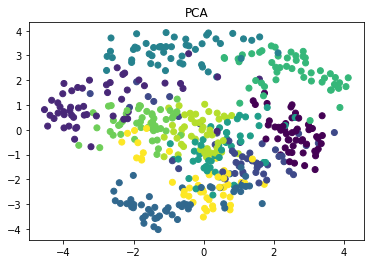

get affinity matrix
 25 8.491 10.000
 50 10.445 10.000
 75 10.133 10.000
100 9.314 10.000
run t-SNE
  0 2.409
 50 2.197
100 2.062
150 1.845
200 1.695


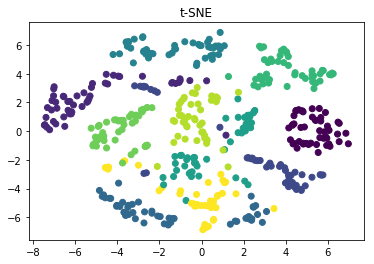

In [3]:
import utils
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# read input dataset
X,color=utils.get_data(mode=1)

# run PCA
U,W,_ = np.linalg.svd(X,full_matrices=False)
Y0 = U[:,:2]*W[:2]
plt.scatter(*Y0.T,c=color); plt.title('PCA')
plt.show()

# run TSNE starting with PCA embedding as an initial solution
Y = TSNE(X,Y0,perplexity=10,learningrate=5.0)
plt.scatter(*Y.T,c=color); plt.title('t-SNE')
plt.show()

## Experimenting With t-SNE (20P)

The file `utils.py` contains a method `get_data(type)` that provides three datasets:

* A collection of digits (less complex than MNIST)
* Boston housing dataset
* Iris dataset

Using your implementation of t-SNE, and running it on the various dataset and with specific training parameters, answer the questions below. Along with your textual answers, include relevant results from running t-SNE in the code cell beneath each question where you should run code with certain parameters (perplexity, learning rate, choice of dataset) relevant to your answer.

How does perplexity and learning rate impact performance? What kind of extreme behaviour these parameters can cause?

##### The target perplexity is achieved iteratively by adjusting the variance σi, that is centered over each high-dimensional datapoint xi. Perplexity is a function of the Shannon entropy of Pi, which in turn, is a function of the conditional probability pi and increases monotonically with it (i.e. higher values of perplexity imply necessarelly higher conditional probability pi). This fact has a direct effect on the value of the gradient at each step of the t-SNE iterative process. For smaller perplexity values, the gradient δC/δy will act as a repealing force between data points in the lower dimensional space, which leads to more disperse and overlapping clusters. For extreme high values of perplexity, the gradient δC/δy will pull the data points together around the perimeter of a circle.

##### The learning rate has a major influnce in the number of steps needed in order to achive a minimum in the objective function. A small learning rate might need to many iterations to reach a global minimum, where as a too high learning rate will miss the global minimum independently of how many iteration steps are performed. 

Loading boston housing


Varying Preplexity (fixed Learning Rate of 50)


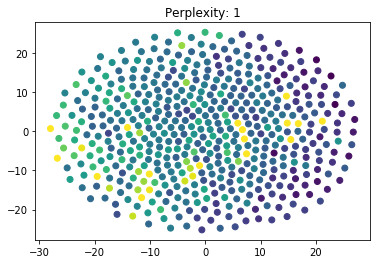

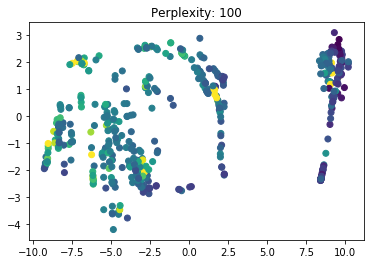

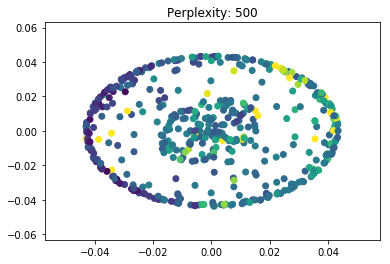



Varying Learning Rate (fixed Preplexity of 500)


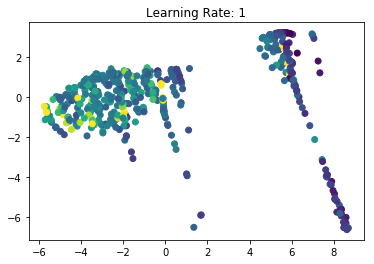

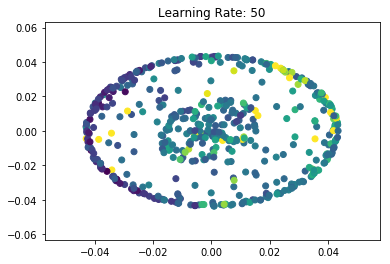

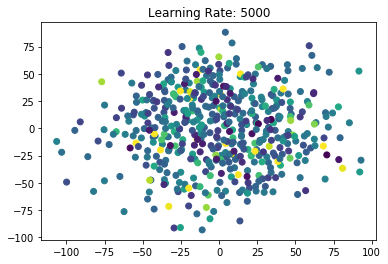

In [4]:
# read input dataset
X,color=utils.get_data(mode=2)

# SVD decomposition
U,W,_ = np.linalg.svd(X,full_matrices=False)
Y0 = U[:,:2]*W[:2]

# run TSNE with fixed learning rate
print('\n')
print('Varying Preplexity (fixed Learning Rate of 50)')
Y1 = TSNE(X,Y0,perplexity=1,learningrate=50.0, info=False)
Y2 = TSNE(X,Y0,perplexity=100,learningrate=50.0, info=False)
Y3 = TSNE(X,Y0,perplexity=500,learningrate=50.0, info=False)
plt.scatter(*Y1.T,c=color); plt.title('Perplexity: 1')
plt.show()
plt.scatter(*Y2.T,c=color); plt.title('Perplexity: 100')
plt.show()
plt.scatter(*Y3.T,c=color); plt.title('Perplexity: 500')
plt.show()

# run TSNE with fixed perplexity
print('\n')
print('Varying Learning Rate (fixed Preplexity of 500)')
Y1 = TSNE(X,Y0,perplexity=500,learningrate=1.0, info=False)
Y2 = TSNE(X,Y0,perplexity=500,learningrate=50.0, info=False)
Y3 = TSNE(X,Y0,perplexity=500,learningrate=5000.0, info=False)
plt.scatter(*Y1.T,c=color); plt.title('Learning Rate: 1')
plt.show()
plt.scatter(*Y2.T,c=color); plt.title('Learning Rate: 50')
plt.show()
plt.scatter(*Y3.T,c=color); plt.title('Learning Rate: 5000')
plt.show()

What kind of insight into the dataset you're dealing with can tSNE provide? Show one such example.

##### As a subproduct of the t-SNE iteration process, similar data points will have a tendency to cluster together in the lower dimensional space. This can be particulary usefull in classification tasks. For example, the t-SNE 2d mapping of the digits data set clearly shows different clusters corresponding to each individual digit. Which simplifys the classification task by reducing the dimensionality of the problem at hand, and provides an insight of the underlying structure of the original data. 

Loading digits


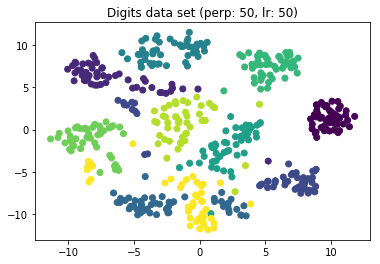

In [5]:
# read input dataset
X,color=utils.get_data(mode=1)

# SVD decomposition
U,W,_ = np.linalg.svd(X,full_matrices=False)
Y0 = U[:,:2]*W[:2]

# run TSNE with fixed learning rate
Y = TSNE(X,Y0,perplexity=50,learningrate=50.0, info=False)
plt.scatter(*Y.T,c=color); plt.title('Digits data set (perp: 50, lr: 50)')
plt.show()

How does the embedding evolve during the optimization procedure (i.e. how are the clusters being formed progressively)?

##### During the optimization procedure, data points that have greater similarity are 'pulled' together and dissimilar data points are 'pushed' apart.

Loading iris


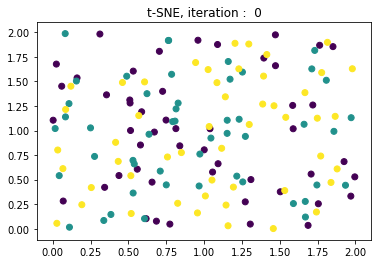

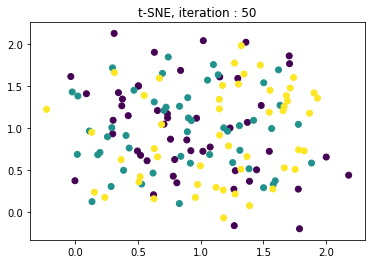

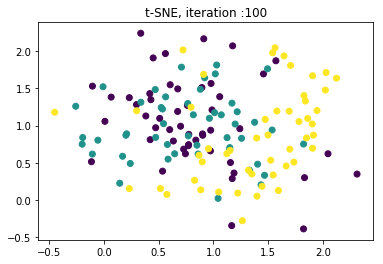

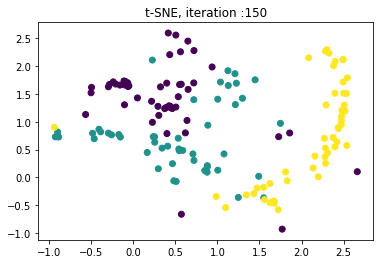

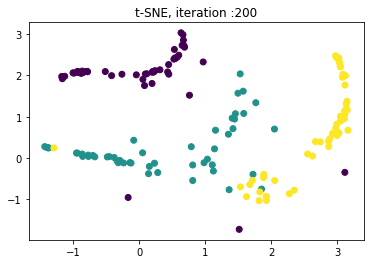

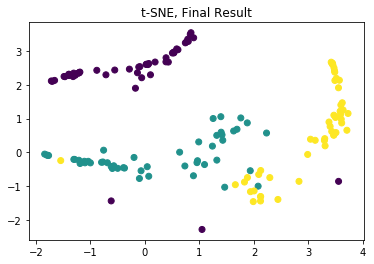

In [6]:
# read input dataset
X,color=utils.get_data(mode=3)

# Random initial embending space
Y0 = np.random.uniform(0, 2, size=(len(X),2))

# run TSNE starting with PCA embedding as an initial solution
Y = TSNE(X,Y0,perplexity=25,learningrate=1.0, plot=True, info=False)
plt.scatter(*Y.T,c=color); plt.title('t-SNE, Final Result')
plt.show()